# Final Project Foundamentals of Data Science
### Solar Eclipse phases classification
#### Luca Moresca, Nicholas Suozzi, Valerio Santini

---------
-   **Titolo del progetto:** Classificazione delle fasi dell'eclissi solare 
-   **Autori:** Luca Moresca, Nicholas Suozzi, Valerio Santini
-   **Descrizione del problema:** Fornire una breve panoramica del problema della classificazione delle fasi dell'eclissi solare. Evidenziare l'importanza dello studio delle eclissi solari per la comprensione dell'interazione tra Sole e Terra.
-   **Obiettivo del progetto:** Definire chiaramente l'obiettivo del progetto, ovvero sviluppare un modello in grado di classificare accuratamente le diverse fasi di un'eclissi solare da immagini.


### Abstract


In [1]:
if True:
    %pip install -qqq numpy scipy matplotlib pandas scikit-learn seaborn tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
# import seaborn as sns
# from tqdm import tqdm
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import os
# from pathlib import Path
import json
from PIL import Image
from scipy.signal import convolve2d
import math
from scipy.ndimage import convolve1d
# from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
# from skimage import io, color
from skimage.measure import label, regionprops
# from skimage.draw import rectangle
from skimage.filters import threshold_otsu
from typing import List, Tuple, Optional, Dict, Union
from concurrent.futures import ThreadPoolExecutor
import time
import cv2
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

In [3]:
# Usefull for histograms, taken from homework 1

def rgb2gray(rgb: np.ndarray) -> np.ndarray:
    """
    Converts RGB images to grayscale.

    Args:
        rgb (np.ndarray): RGB image.

    Returns:
        gray (np.ndarray): Grayscale image.
    """
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def plot_pictures(
    imgs: List[np.ndarray],
    xlabels: List[str],
    nrows: int,
    ncols: int,
    show: bool = True,
    cmap: Union[str, List[str]] = "gray",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    same_scale: bool = False,
) -> List[plt.Axes]:
    """
    Plots images in a grid.

    Args:
        imgs (list[np.ndarray]): List of images.
        xlabels (list[str]): List of xlabels.
        nrows (int): Number of rows.
        ncols (int): Number of columns.
        show (bool): Whether to show the plot.
        cmap (Union[str, List[str]]): Color map.
        vmin (float): Minimum value.
        vmax (float): Maximum value.
        same_scale (bool): Whether to use the same scale for all images.

    Returns:
        axs (list[matplotlib.axes._subplots.AxesSubplot]): List of axes.
    """
    fig, axs = plt.subplots(nrows, ncols,
                            width_ratios=[img.shape[1] / img.shape[0] for img in imgs],
                            sharey=same_scale,
                            figsize=(ncols * 4, nrows * 4))
    axs = axs.flatten()

    for i, (img, ax) in enumerate(zip(imgs, axs)):
        if isinstance(cmap, list):
            current_cmap = cmap[i]
        else:
            current_cmap = cmap
        im = ax.imshow(img, cmap=current_cmap, vmin=vmin, vmax=vmax)


        ax.set_title(xlabels[i])
        ax.axis('off')
    plt.tight_layout()

    if show:
        plt.show()
    else:
        return axs

## 1. Dataset Analysis

The “Great American Eclipse” in 2017 offered a unique opportunity for US citizens across the entire continent to experience the awe-inspiring changes that occur during rare total solar eclipses (TSEs). The goal of the 2017 Eclipse Megamovie was to obtain enough pictures of the Great American Total Solar Eclipse to create a movie of the solar corona in order to better study it. Over 2,000 volunteers submitted 50,000 images and a movie was made only a few hours after the Moon's shadow left the U.S. A few months later another, better aligned and more closely edited, movie was released. The Eclipse Megamovie team of scientists processed images to create High Dynamic Range (HDR) images to capture the structures within the high dynamic range of the solar corona from the Sun's photosphere out ~3 solar radii.
https://eclipsemegamovie.org

Eclipse megamovie is a project being carried out by a group of researchers in collaboration with NASA. The focus of this project is to make a video that can facilitate research into a rare event such as the eclipse that occurred in the United States in 2017. To realise this project, American citizens were asked to send in photographs taken during the eclipse. The dataset therefore contains semi-professional and amateur images, taken under conditions that are not always optimal.

In [4]:
# Print the .json file with the label.
with open('eclipse-megamovie/label_num_to_phase_map.json', 'r') as file:
    data = json.load(file)
print(json.dumps(data, indent=4))

{
    "TotalSolarEclipse": 0,
    "0to25percentPartialEclipse": 1,
    "26to55percentPartialEclipse": 2,
    "56to95percentPartialEclipse": 3,
    "Darks": 4,
    "DiamondRing_BaileysBeads_SolarEclipse": 5,
    "Flats": 6,
    "NotASolarEclipse": 7
}


In [5]:
# Print the .csv file with labels and images names.
df = pd.read_csv("eclipse-megamovie/train.csv")
print(df)

                                              image_id  label
0    0089d49c892b6d15513690521c08eb5ffc93fe24a4926c...      0
1    00ade9976af2090eae8e6e5eed3096f12dc7235adb3c12...      0
2    ff6c7fea709fd7bbb1790668dc664b30ed72cfb2cae0a0...      0
3    eee7f9abf29297179aa070518671bfc9a60c9f8a67e62a...      0
4    fcc12656dacc1867bbea8438635bf52b4b1920cac3e48b...      0
..                                                 ...    ...
490  4f99a8e1efe0a51fca127bcdabfb1165523dee8730dbba...      7
491  fb9026a6d96719729ef44c61e76c5b007b17784f6ddb8f...      7
492  0160498b80fcf8f55002627f1f3eb7c6969675f7877410...      7
493  021c7d3386821090186bd925a8d13d9cc509db69550956...      7
494  018b72bf1ef4f3a184c0029ffcff3dde17f4a883ef472f...      7

[495 rows x 2 columns]


The .json file relates the eclipse phases to the corresponding labels in the ‘train.csv’ file, which will help the training phase by already having a correspondence between label and image. The csv file then contains a classification of the various training images useful for the model. 

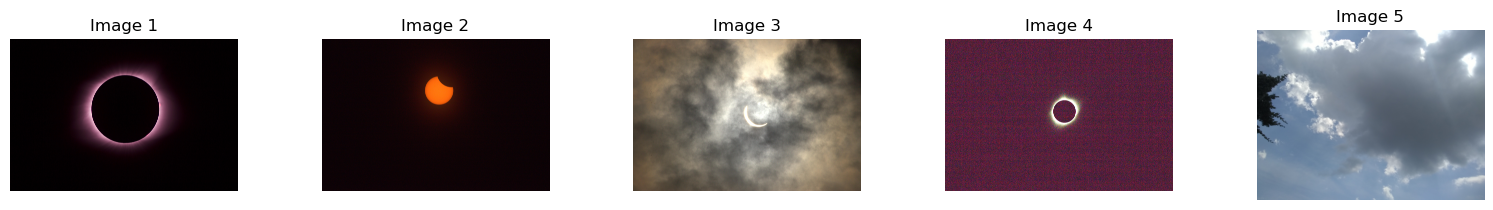

In [6]:
# Plot of some images in the train dataset

img1 = mpimg.imread('eclipse-megamovie/train/00a0f91f0e7ece88ebaeab2a2050cdc0d72c5ea0b56c601dfaf800077df44c51.jpg')
img2 = mpimg.imread('eclipse-megamovie/train/00a4af4cc3f2a667c80331051a733e8dae2477d682d7dcef3e895f6f923dd86a.jpg')
img3 = mpimg.imread('eclipse-megamovie/train/00c11b16fd6426a88039c8b27e2511e2e770b65e0eb9daab720d3e6ca996bc06.jpg')
img4 = mpimg.imread('eclipse-megamovie/train/001e6704a60798684f1656713b593e6a56de81474e7173a31936589cd62f13e8.jpg')
img5 = mpimg.imread('eclipse-megamovie/train/4f99a8e1efe0a51fca127bcdabfb1165523dee8730dbba0df5436a7de70dc16e.jpg')

fig, axes = plt.subplots(1, 5, figsize=(16, 4))
fig.tight_layout(pad=3.0)

axes[0].imshow(img1)
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title("Image 2")
axes[1].axis('off')

axes[2].imshow(img3)
axes[2].set_title("Image 3")
axes[2].axis('off')

axes[3].imshow(img4)
axes[3].set_title("Image 4")
axes[3].axis('off')

axes[4].imshow(img5)
axes[4].set_title("Image 5")
axes[4].axis('off')

plt.show()


* As can be seen in the figure above, our dataset consists of various types of images. Some contain eclipses, others do not. The images have different perspectives, are taken with different devices and have different backgrounds. 
This presents us with the challenge of correctly identifying the content of each image accurately, we must be able to classify images that do not contain eclipses as impostors. 
On a numerical level, the dataset consists of a training set and a test set. In addition, there is a .csv file containing the name of some images and a label showing the corresponding eclipse phase. In addition, there is a .json file that explains what each label corresponds to on a phase level. 
There are 496 images in the training set and 140 images in the test set. The dataset is restricted and this will result in an appropriate treatment of the images to improve the performance of the model. 

* Each image has a different resolution, considering that they are obtained with various devices. The eclipse within each image is not always perfectly sharp or centred, making the model more elastic in various cases.


## 2. Preprocessing delle immagini

-   **Spiegazioni:** Descrivere le tecniche di preprocessing delle immagini utilizzate, spiegando la logica alla base di ogni scelta.
-   Ad esempio, se si ridimensionano le immagini, spiegare perché è necessario farlo e quale dimensione si è scelto di utilizzare.
-   Se si convertono le immagini in scala di grigi, giustificare questa scelta.
-   Se si normalizzano i valori dei pixel, spiegare il metodo di normalizzazione utilizzato e perché è importante.
-   **Codice:** Fornire il codice Python utilizzato per il preprocessing delle immagini.
-   **Visualizzazioni:** Mostrare alcuni esempi di immagini pre-elaborate, confrontandole con le immagini originali.


### Suggerimenti per il Preprocessing delle Immagini per la Classificazione delle Fasi di Eclissi Solare

Ecco alcuni suggerimenti per descrivere le tecniche di preprocessing delle immagini che potresti utilizzare per il tuo progetto di classificazione delle fasi di eclissi solare, insieme alla logica alla base di ogni scelta:

*   **Conversione in scala di grigi:** La conversione delle immagini in scala di grigi è una scelta comune nel preprocessing delle immagini, soprattutto quando il colore non è una caratteristica discriminante per il compito in questione. Nel caso della classificazione delle fasi di eclissi solare, le informazioni di colore potrebbero non essere essenziali per distinguere le diverse fasi. La conversione in scala di grigi riduce la complessità dei dati e la quantità di informazioni da elaborare, il che può accelerare i tempi di addestramento del modello e potenzialmente migliorare le sue prestazioni.
*   **Riduzione del rumore:** Le immagini possono contenere rumore che può influenzare negativamente le prestazioni del modello. La riduzione del rumore può essere realizzata utilizzando filtri come il filtro gaussiano.  Applicare un filtro gaussiano prima di altre operazioni di preprocessing può aiutare a migliorare la qualità delle immagini e a rendere più evidenti le caratteristiche importanti per la classificazione.
*   **Downscaling:**  Se le immagini originali hanno una risoluzione molto alta, il downscaling può essere utile per ridurre la quantità di dati da elaborare e accelerare i tempi di addestramento. La dimensione da utilizzare dipenderà dalla risoluzione originale delle immagini e dalla complessità del modello. È importante scegliere una dimensione che conservi le caratteristiche essenziali per la classificazione, evitando al contempo di perdere troppe informazioni.  Assicurati di applicare un filtro gaussiano prima del downscaling per evitare l'aliasing. 
*   **Normalizzazione:** La normalizzazione dei valori dei pixel è un'altra tecnica comune nel preprocessing delle immagini.  Può essere eseguita sottraendo la media e dividendo per la deviazione standard dei valori dei pixel. Questo processo porta tutti i valori dei pixel in un intervallo simile, il che può aiutare a migliorare le prestazioni del modello, soprattutto quando si utilizzano algoritmi di apprendimento automatico sensibili alla scala dei dati.

**Tecniche utili dagli homework:**

*   **Dal Homework 1:** Tutte le tecniche elencate (riduzione del rumore, downscaling, normalizzazione e conversione in scala di grigi) possono essere utili per il tuo progetto.
*   **Dal Homework 2:** La codifica one-hot sarà necessaria per le etichette delle fasi dell'eclissi. La gestione dei valori mancanti potrebbe essere utile se il tuo set di dati contiene immagini incomplete o danneggiate. L'espansione polinomiale e lo scaling potrebbero non essere necessari per il tuo progetto, in quanto sono tecniche più comunemente utilizzate per dati numerici non immagine.

### Tecniche Essenziali di Preprocessing per Immagini di Eclissi Solari Variabili

Dato che si ha a che fare con una vasta gamma di immagini scattate da amatori, che presentano diverse proporzioni, dimensioni del sole e posizioni del sole all'interno dell'immagine, è fondamentale applicare tecniche di preprocessing essenziali per preparare i dati per l'addestramento del modello di classificazione delle fasi dell'eclissi. 

Oltre alle tecniche di base già discusse (conversione in scala di grigi, riduzione del rumore, downscaling e normalizzazione), ecco alcune altre tecniche molto essenziali da considerare:

*   **Ritaglio e ridimensionamento:** Le immagini potrebbero avere bordi o aree irrilevanti che non contribuiscono alla classificazione delle fasi dell'eclissi. Il ritaglio può essere utilizzato per rimuovere queste aree e focalizzare l'attenzione sulla regione di interesse, ovvero il sole e la corona solare. Dopo il ritaglio, tutte le immagini dovrebbero essere ridimensionate a una dimensione uniforme per garantire la compatibilità con il modello. Poiché le proporzioni delle immagini originali possono variare, è possibile utilizzare un ridimensionamento con padding per mantenere le proporzioni originali, aggiungendo bordi neri attorno all'immagine ritagliata per raggiungere la dimensione desiderata. 
*   **Centratura del Sole:** La posizione del sole all'interno dell'immagine può variare notevolmente. Per migliorare le prestazioni del modello, è utile centrare il sole in tutte le immagini. Ciò può essere ottenuto tramite algoritmi di rilevamento degli oggetti o, in casi più semplici, analizzando l'istogramma dell'immagine per identificare la regione più luminosa (presumibilmente il sole) e spostarla al centro dell'immagine.

### Come Rilevare e Centrare il Sole nelle Immagini di Eclissi

Per centrare il sole in un'immagine, un metodo robusto è quello di utilizzare la **combinazione di rilevamento dei bordi, piramide gaussiana e template matching**, tecniche già presenti negli homework forniti.

**Ecco i passaggi**

1. **Rilevamento dei Bordi**

2. **Piramide Gaussiana** 

3. **Template Matching** 

4. **Selezione della Scala Migliore** 

5. **Centratura** 

**Note Aggiuntive**

* Per migliorare ulteriormente la precisione del rilevamento, è possibile utilizzare un template del sole più sofisticato, che tenga conto della corona solare.
* Dopo la centratura, potrebbe essere necessario ritagliare l'immagine per rimuovere eventuali bordi neri aggiunti durante il ridimensionamento con padding.

Questo metodo offre una soluzione efficace per rilevare e centrare il sole in immagini di eclissi solare, utilizzando tecniche già familiari dagli homework e garantendo una buona robustezza e flessibilità.




### Conversione in scala di grigi 

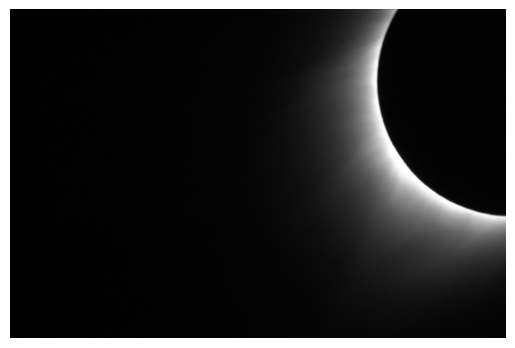

In [7]:
path = "eclipse-megamovie/train/f5b6b5e1fe97a2070a105c2031d1d84d4cc764746dc9d4c5a94db9b099d976a2.jpg"
#path = "eclipse-megamovie/train/00a0f91f0e7ece88ebaeab2a2050cdc0d72c5ea0b56c601dfaf800077df44c51.jpg"
image = cv2.imread(path)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# cv2.imwrite('/Users/valeriosantini/Desktop/or.jpg', image)
# cv2.imwrite('/Users/valeriosantini/Desktop/gr.jpg', gray_image)

plt.imshow(gray_image, cmap="gray")
plt.axis('off')
plt.show()

COMMENTARE

### Denoising

In [8]:
def gauss(sigma: float, filter_size: int) -> Tuple[np.ndarray, np.ndarray]:
    Gx = np.array([])
    k = (filter_size - 1) // 2  
    x = np.arange(-k, k + 1)
    cost = 1/(np.sqrt(2*np.pi)*sigma)
    Gx = np.append(Gx, cost * np.exp(-(x**2)/(2*sigma**2)))
    return Gx, x

def gaussfiltering(img: np.ndarray, sigma: float) -> np.ndarray:
    filter_size = np.round(6 * sigma)

    Gx, _ = gauss(sigma, filter_size)
    out = convolve1d(img, Gx, axis = 1)
    out = convolve1d(out, Gx, axis = 0)
    
    return out

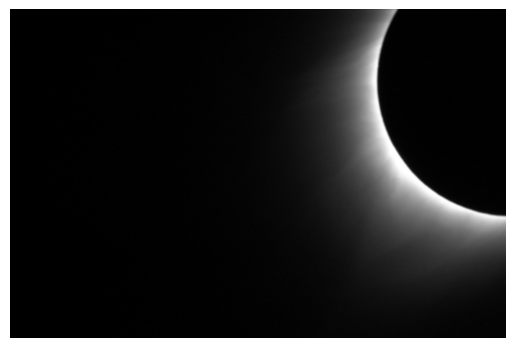

In [9]:
sigma = 3

smt_img = gaussfiltering(gray_image, sigma)

plt.imshow(smt_img, cmap="gray")
plt.axis('off')
plt.show()

COMMENTARE


### Normalization

The normalize function performs linear normalization of an image to scale pixel values in the range $[0,1]$

In [10]:
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

In [11]:
nrm_img = normalize(smt_img)

### Eclipse Isolation

In [12]:
def detect_eclipse(image):


    offset = 128
    intensity_threshold = threshold_otsu(image)
    bright_pixels = image > intensity_threshold

    labeled_bright = label(bright_pixels)
    regions = regionprops(labeled_bright)


    if len(regions) == 0:
        print("Nessuna regione luminosa rilevata.")
        return None
    largest_region = max(regions, key=lambda r: r.area)
    minr, minc, maxr, maxc = largest_region.bbox

    height = maxr - minr + offset
    width = maxc - minc + offset
    
    side_length = max(height, width)

    center_r = (minr + maxr) // 2
    center_c = (minc + maxc) // 2

    minr = center_r - side_length // 2
    maxr = center_r + side_length // 2
    minc = center_c - side_length // 2
    maxc = center_c + side_length // 2
    
    if minr < 0:
        maxr += abs(minr)  
        minr = 0
    if maxr > image.shape[0]:
        minr -= maxr - image.shape[0]
        maxr = image.shape[0]

    if minc < 0:
        maxc += abs(minc)   
        minc = 0
    if maxc > image.shape[1]:
        minc -= maxc - image.shape[1]
        maxc = image.shape[1]

    minr = max(0, minr)
    minc = max(0, minc)
    maxr = min(image.shape[0], maxr)
    maxc = min(image.shape[1], maxc)

    cropped_image = image[minr:maxr, minc:maxc]



    return cropped_image


This function identifies and isolates the brightest region of an image by performing a square crop centered on it. It uses Otsu's threshold method to determine the brightest pixels and then identifies the largest connected region using regionprops. After calculating an extended bounding box with an offset, it determines a square crop based on the longest side of the detected area, centering the crop on the bright region.

If the crop exceeds the boundaries of the image, the edges are corrected to keep the crop within the image itself. In the absence of bright regions, the function returns None.

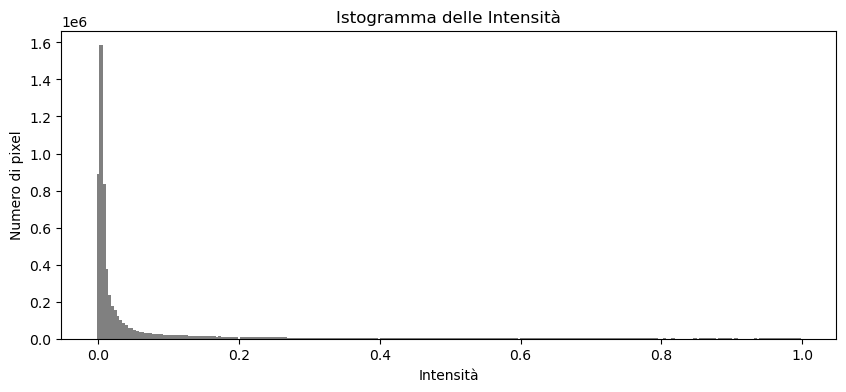

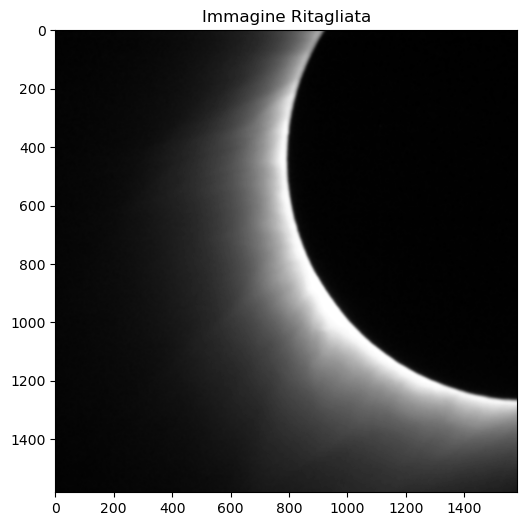

In [13]:
cropped_img = detect_eclipse(nrm_img)


#Print Histogram
hist, bins = np.histogram(nrm_img.flatten(), bins=256, range=(0, 1))
plt.figure(figsize=(10, 4))
plt.title("Istogramma delle Intensità")
plt.bar(bins[:-1], hist, width=0.005, color='gray')
plt.xlabel("Intensità")
plt.ylabel("Numero di pixel")
plt.show()

#Print Cropped Img
plt.figure(figsize=(12, 6))
plt.title("Immagine Ritagliata")
plt.imshow(cropped_img, cmap='gray')
plt.show()


### Downscaling

In [14]:
def downscale(
    img: np.ndarray,
    target_resolution: tuple = (512, 512),
    sigma: float = 1
) -> np.ndarray:

    if img.ndim == 3:   
        img_blurred = np.zeros_like(img)
        for c in range(3):
            img_blurred[:, :, c] = gaussfiltering(img[:, :, c], sigma)
    else:   
        img_blurred = gaussfiltering(img, sigma)

    downscaled_img = resize(img_blurred, target_resolution, anti_aliasing=True)

    if img.ndim == 3:  
        downscaled_img = np.clip(downscaled_img * 255, 0, 255).astype(np.uint8)
        img_blurred = np.clip(img_blurred * 255, 0, 255).astype(np.uint8)

    return downscaled_img


The downscale function downscales an image to a specified target resolution, applying Gaussian pre-filtering to reduce artifacts due to sampling.

Main details:

* Accepts an input image (img) and an optional target resolution parameter (target_resolution, default (512, 512)).
* Applies Gaussian filtering (gaussfiltering) to smooth the image before resizing.
* Uses skimage.transform.resize to resize the image, with anti_aliasing option to preserve visual quality.
* Converts filtered and resized images to 8-bit (uint8) format to ensure compatibility and optimize memory.

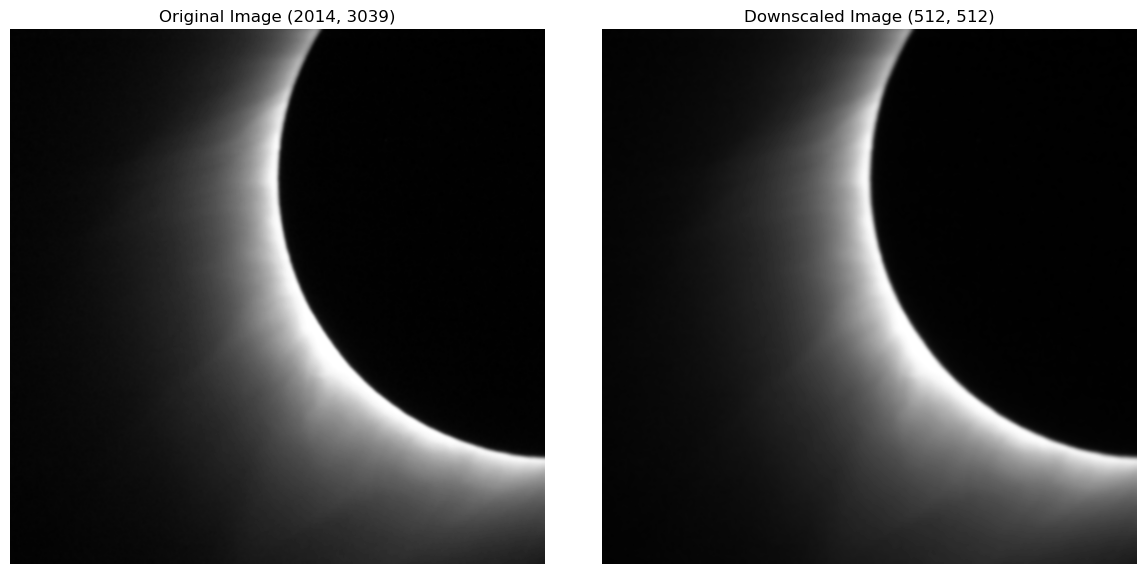

In [15]:
downscaled = downscale(cropped_img, target_resolution=(512, 512), sigma=3)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
plt.gray()
fig.tight_layout()

axes[0].imshow(cropped_img)
axes[0].set_title(f"Original Image {smt_img.shape}")
axes[0].axis('off')
axes[1].imshow(downscaled)
axes[1].set_title(f"Downscaled Image {downscaled.shape}")
axes[1].axis('off')

plt.show()

In [16]:
def preprocess_image(path: str, target_resolution: tuple = (512, 512), sigma: float = 3, offset: int = 128):
    image = cv2.imread(path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    smt_img = gaussfiltering(gray_image, sigma)
    nrm_img = normalize(smt_img)
    cropped_img = detect_eclipse(nrm_img)
    downscaled_img = downscale(cropped_img, target_resolution, sigma)
    downscaled_img *= 255
    return downscaled_img

In [17]:
def get_image_paths(folder_path):
    supported_formats = ('.jpg', '.png')
    return [
        os.path.join(folder_path, filename)
        for filename in os.listdir(folder_path)
        if filename.lower().endswith(supported_formats)
    ]

def preprocess_images_in_parallel(folder_path, output_folder, target_resolution=(512, 512), sigma=3, num_workers=4):
    image_paths = get_image_paths(folder_path)

    def process_and_save(path):
        try:
            preprocessed_image = preprocess_image(path, target_resolution, sigma)
            if preprocessed_image is None:
                print(f"Errore nella preprocessazione dell'immagine: {path}")
                return
            
            output_path = os.path.join(output_folder, os.path.basename(path))
            success = cv2.imwrite(output_path, preprocessed_image)
            if not success:
                print(f"Errore nel salvataggio dell'immagine: {output_path}")
        except Exception as e:
            print(f"Errore durante il processamento di {path}: {e}")

    os.makedirs(output_folder, exist_ok=True)
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        executor.map(process_and_save, image_paths)
        
        
def preprocess_images_sequentially(folder_path, output_folder, target_resolution=(512, 512), sigma=3):
    image_paths = get_image_paths(folder_path)
    os.makedirs(output_folder, exist_ok=True)
    for path in image_paths:
        try:
            preprocessed_image = preprocess_image(path, target_resolution, sigma)            
            if preprocessed_image is None:
                print(f"Errore nella preprocessazione dell'immagine: {path}")
                continue
            output_path = os.path.join(output_folder, os.path.basename(path))
            success = cv2.imwrite(output_path, preprocessed_image)
            if not success:
                print(f"Errore nel salvataggio dell'immagine: {output_path}")
        except Exception as e:
            print(f"Errore durante il processamento di {path}: {e}")

In [18]:
input_folder_train = "eclipse-megamovie/train"
output_folder_train = "train_preprocessed"
input_folder_test = "eclipse-megamovie/test"
output_folder_test = "test_preprocessed"

target_resolution = (512, 512)
sigma = 3

# Training set parallel preprocessing
# print(f"Inizio preprocessing per il training set...")
# start_time = time.time()
# preprocess_images_in_parallel(input_folder_train, output_folder_train, target_resolution, sigma, num_workers=8)
# print(f"Preprocessing del training set completato. Immagini salvate in {output_folder_train}.")
# print(f"Tempo con parallelizzazione: {time.time() - start_time:.2f} secondi")

# #COMMENTATO PER PRESTAZIONI
# # Training set sequential preprocessing
# start_time = time.time()
# preprocess_images_sequentially(input_folder_train, output_folder_train, target_resolution, sigma)
# print(f"Tempo senza parallelizzazione: {time.time() - start_time:.2f} secondi")

# Test set parallel
# print(f"Inizio preprocessing per il test set...")
# preprocess_images_in_parallel(input_folder_test, output_folder_test, target_resolution, sigma, num_workers=8)
# print(f"Preprocessing del test set completato. Immagini salvate in {output_folder_test}.")


Il preprocessing viene applicato utilizzando la parallelizzazione di Python, (approfondire l'argomento), l'output senza salvare le immagini è questo: 

* Tempo con parallelizzazione: 97.14 secondi (1.6 minuti)
* Tempo senza parallelizzazione: 379.42 secondi (6.31 minuti)

Il test non viene applicato al dataset di test, perchè per convenienza di tempi viene usata solo la parallelizzazione


In [19]:
class SolarEclipseDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.target_resolution = target_resolution
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.data.iloc[idx, 0])
        image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, self.target_resolution)
        label = self.data.iloc[idx, 1]


        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

csv_file = "eclipse-megamovie/train.csv"
image_folder = "train_preprocessed/"
dataset = SolarEclipseDataset(csv_file, image_folder, transform=transform)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [20]:
class SolarEclipseCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(SolarEclipseCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Input: 1x512x512 -> Output: 32x512x512
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: 64x512x512
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Riduce dimensione: Output: 64x256x256
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Output: 128x256x256
        self.fc1 = nn.Linear(128 * 64 * 64, 512)  # Flatten -> Fully connected
        self.fc2 = nn.Linear(512, num_classes)  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))  # Output: 128x64x64
        x = x.view(-1, 128 * 64 * 64)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [21]:
# # Istanziamento del modello, loss e ottimizzatore
#device = torch.device("mps" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SolarEclipseCNN(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()  # Loss per classificazione multiclass
optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 7
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for images, labels in dataloader:
#         images, labels = images.to(device), labels.to(device)

#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         # Backward pass e ottimizzazione
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

# print("Training completato.")


In [22]:
# # Save the trained model 
model_path = "eclipse-megamovie/solar_net.pth"
# torch.save(model.state_dict(), model_path)

In [23]:
# COMMENTO IL TRAINING LOOP E AGGIUNGO IL CARICAMENTO DEL MODELLO
model.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [24]:
# Modalità valutazione
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Report di classificazione
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Matrice di confusione
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       187
           1       0.98      0.90      0.94        52
           2       0.69      1.00      0.82        38
           3       0.95      0.67      0.78        57
           4       0.98      0.79      0.88        63
           5       0.96      0.61      0.75        44
           6       0.77      0.94      0.85        18
           7       0.87      0.92      0.89        36

    accuracy                           0.88       495
   macro avg       0.88      0.85      0.85       495
weighted avg       0.90      0.88      0.88       495

Confusion Matrix:
[[186   0   0   0   0   0   0   1]
 [  1  47   3   0   1   0   0   0]
 [  0   0  38   0   0   0   0   0]
 [  7   0  10  38   0   1   0   1]
 [  9   0   0   1  50   0   3   0]
 [  8   1   4   1   0  27   0   3]
 [  1   0   0   0   0   0  17   0]
 [  1   0   0   0   0   0   2  33]]


Now we can try preprocessing with an image given its path

In [25]:
class CustomTestDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_names = [
            f for f in os.listdir(image_folder) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_folder, img_name)
        try:
            image = Image.open(img_path).convert("L")
        except UnidentifiedImageError:
            print(f"Immagine non valida: {img_path}")
            return None, img_name

        if self.transform:
            image = self.transform(image)

        return image, img_name

# Definisci le trasformazioni
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Carica il dataset
image_folder = "train_preprocessed"
test_dataset = CustomTestDataset(image_folder=image_folder, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)

# Metti il modello in modalità di valutazione
model.eval()

# Predizioni
predictions = []
softmax = torch.nn.functional.softmax

with torch.no_grad():
    for data in test_loader:
        images, img_names = data

        # Ignora batch con immagini non valide
        valid_indices = [i for i, img in enumerate(images) if img is not None]
        images = torch.stack([images[i] for i in valid_indices])
        img_names = [img_names[i] for i in valid_indices]

        if len(images) == 0:
            continue

        images = images.to(device)

        # Ottieni predizioni e probabilità
        outputs = model(images)
        probabilities = softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

        # Salva i risultati
        for img_name, label, prob in zip(img_names, predicted.cpu().numpy(), probabilities.cpu().numpy()):
            predictions.append((img_name, label, prob.max()))

# Salva i risultati in un CSV
df = pd.DataFrame(predictions, columns=["Image_Name", "Predicted_Label", "Confidence"])
df.to_csv("eclipse_predictions.csv", index=False)
print("Predizioni salvate in: eclipse_predictions.csv")

Predizioni salvate in: eclipse_predictions.csv


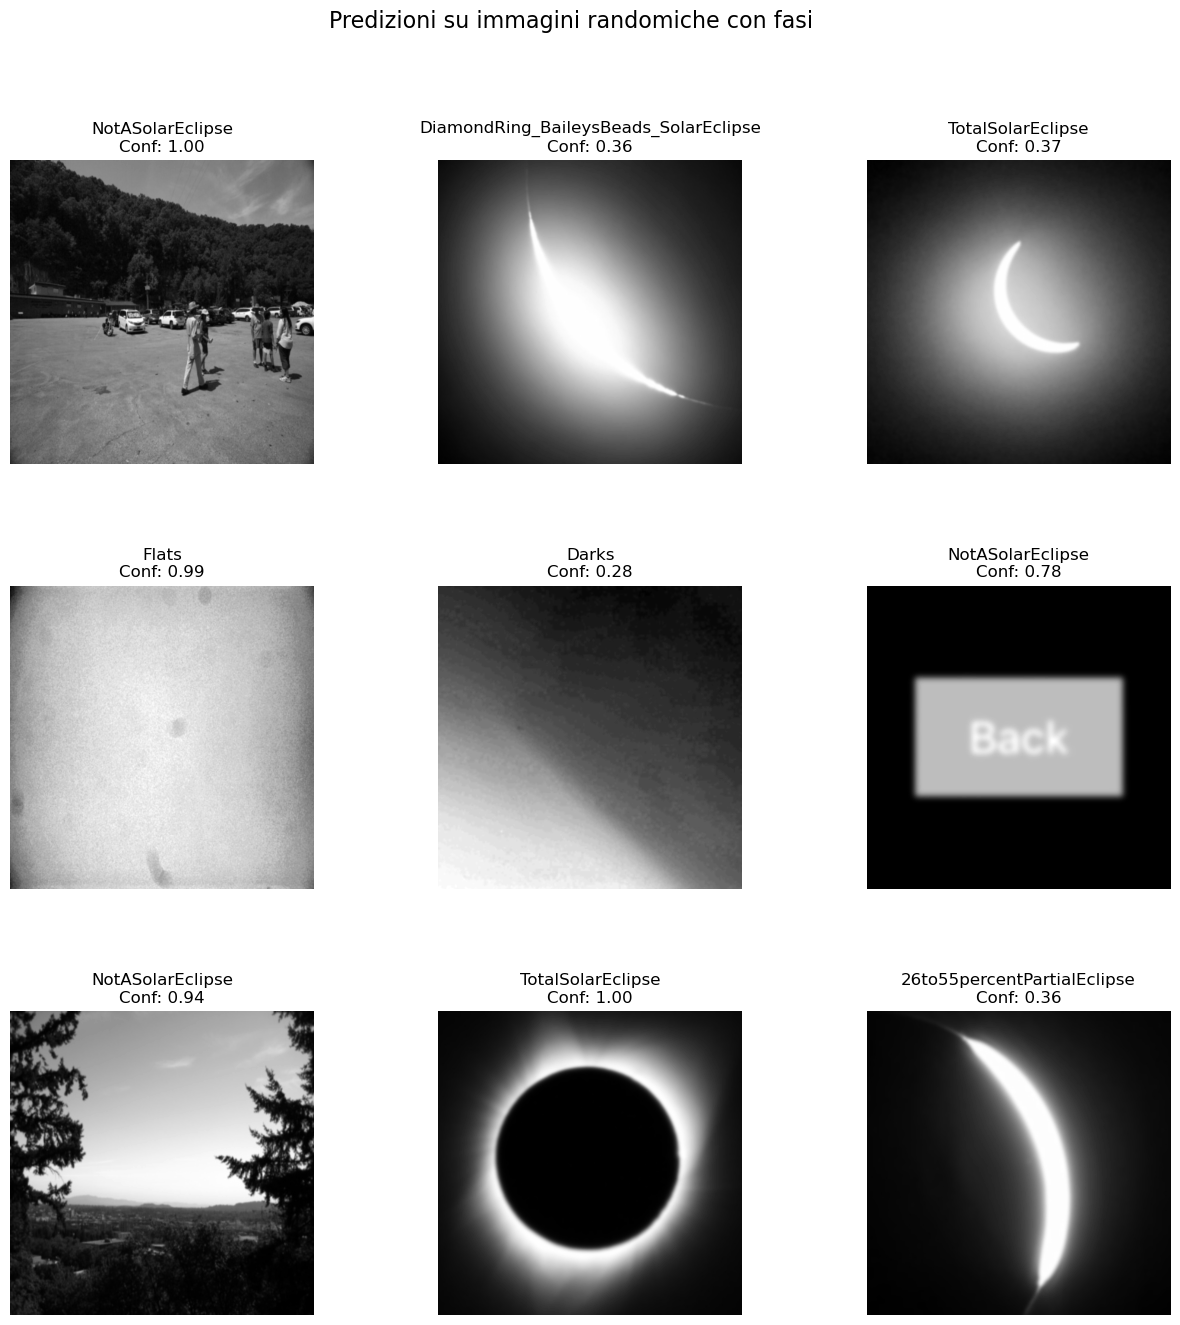

In [26]:
# Percorso del file di mappatura
label_map_path = r"eclipse-megamovie/label_num_to_phase_map.json"

# Carica la mappa delle etichette
with open(label_map_path, "r") as file:
    label_num_to_phase_map = {v: k for k, v in json.load(file).items()}  # Invertiamo chiave-valore

def display_predictions(dataset, predictions, num_images=9):
    """
    Visualizza immagini con predizioni e descrizioni delle fasi in una griglia 3x3.

    Args:
        dataset: Il dataset che contiene le immagini.
        predictions: Lista di tuple (img_name, label, confidence).
        num_images: Numero di immagini da visualizzare. Default: 9 (griglia 3x3).
    """
    # Seleziona immagini randomiche dal dataset
    sample_preds = random.sample(predictions, min(num_images, len(predictions)))

    # Imposta i subplot in una griglia 3x3
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle("Predizioni su immagini randomiche con fasi", fontsize=16)

    # Appiattisci gli assi per iterare facilmente
    axes = axes.flatten()

    for ax, (img_name, label, confidence) in zip(axes, sample_preds):
        # Ottieni il percorso dell'immagine
        img_path = os.path.join(dataset.image_folder, img_name)

        # Carica l'immagine
        image = Image.open(img_path)

        # Ottieni la descrizione della fase
        phase_description = label_num_to_phase_map.get(label, "Sconosciuto")

        # Mostra l'immagine nel subplot
        ax.imshow(image, cmap="gray")
        ax.set_title(f"{phase_description}\nConf: {confidence:.2f}")
        ax.axis("off")

    # Aggiungi spazio tra le immagini
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

# Visualizzazione (opzionale)
display_predictions(test_dataset, predictions)

# Histograms classification 

In [27]:
def gaussdx(sigma: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function computes the first derivative of the 1D Gaussian operator.

    Args:
        sigma (float) : the standard deviation of the Gaussian filter

    Returns:
        Dx (np.ndarray): the first derivative of the 1D Gaussian operator
        x (np.ndarray): the indexes of the 1D Gaussian operator
    """
    #####################################################
    ##              FIX THIS CODE (2 ERRORS)           ##
    #####################################################
    sigma = math.ceil(sigma)
    filter_size = 6 * sigma + 1

    zero_pos = filter_size //2
    x = np.arange(filter_size) - zero_pos  # indexes from -3*sigma to 3*sigma

    Dx = (-x) * np.exp(-(x**2) / (2.0 * sigma**2)) / (math.sqrt(2.0 * np.pi) * sigma**3)

    return Dx, x

In [28]:
def gauss_dxdy(img: np.ndarray, sigma: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function applies the first derivative of the 1D Gaussian operator to the image in the x and y directions.

    Args:
        img (np.ndarray): the input image.
        sigma (float): the standard deviation of the Gaussian filter.

    Returns:
        img_Dx (np.ndarray): the image after applying the first derivative of the 1D Gaussian operator in the x direction.
        img_Dy (np.ndarray): the image after applying the first derivative of the 1D Gaussian operator in the y direction.
    """
    #####################################################
    ##                 FIX THIS CODE                   ##
    #####################################################
    # Gx, _ = gauss(sigma, filter_size=6*sigma)
    # Dx, _ = gaussdx(sigma)
    Dx, _ = gaussdx(sigma)

    # img_Dx = convolve1d(convolve1d(img, Dx), Gx)
    # img_Dy = convolve1d(convolve1d(img, Gx), Dx)
    
    img_Dx = convolve1d(img, Dx, axis=1)
    img_Dy = convolve1d(img, Dx, axis=0)

    return img_Dx, img_Dy

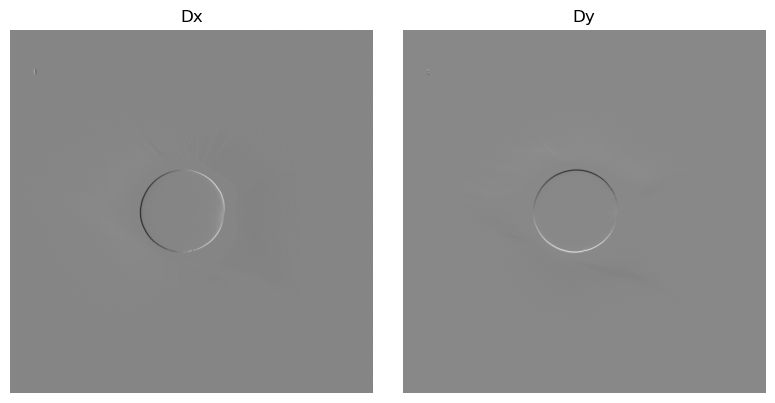

In [130]:
img_color = rgb2gray(np.array(Image.open("eclipse-megamovie/test/0083b50624b619bb66705581d5c08e6fc2dc77574a979835ef01f96f9f19f8b1.jpg")))

img_Dx, img_Dy = gauss_dxdy(img_color, 1)

plot_pictures([img_Dx, img_Dy], ["Dx", "Dy"], 1, 2)

In [53]:
def hist_dxdy(img_gray, num_bins=5):
    """
    This function computes the *joint* histogram of Gaussian partial derivatives of the image in x and y direction.
    Set sigma to 3.0 and cap the range of derivative values is in the range [-6, 6].
    The histogram should be normalized so that the sum of all values equals 1.

    Args:
        img_gray: the input image
        num_bins: number of bins used to discretize each dimension, total number of bins in the histogram should be num_bins^2

    Returns:
        hists: the joint normalized histogram of Gaussian partial derivatives of the image in x and y direction
    """    
    assert len(img_gray.shape) == 2, "image dimension mismatch"
    assert img_gray.dtype in [np.float32, np.float64], "incorrect image type"

    #####################################################
    ##                 FIX THIS CODE                   ##
    #####################################################

    sigma = 3.0
    img_dx, img_dy = gauss_dxdy(img_gray, sigma)

    min_der, max_der = (-6, 6)

    img_dx = img_dx.reshape(-1)
    img_dy = img_dy.reshape(-1)
    
    img_dx = np.clip(img_dx, min_der, max_der) - min_der
    img_dy = np.clip(img_dy, min_der, max_der) - min_der

    hists = np.zeros((num_bins, num_bins), dtype=float)
    bin_range = (max_der - min_der) / num_bins

    bin_dx = np.floor(img_dx / bin_range).astype(int)
    bin_dy = np.floor(img_dy / bin_range).astype(int)
    bin_dx = np.clip(bin_dx, 0, num_bins - 1)
    bin_dy = np.clip(bin_dy, 0, num_bins - 1)

    for i in range(bin_dx.size):
        hists[bin_dx[i], bin_dy[i]] += 1

    hists /= hists.sum()
    hists = hists.flatten()
    return hists

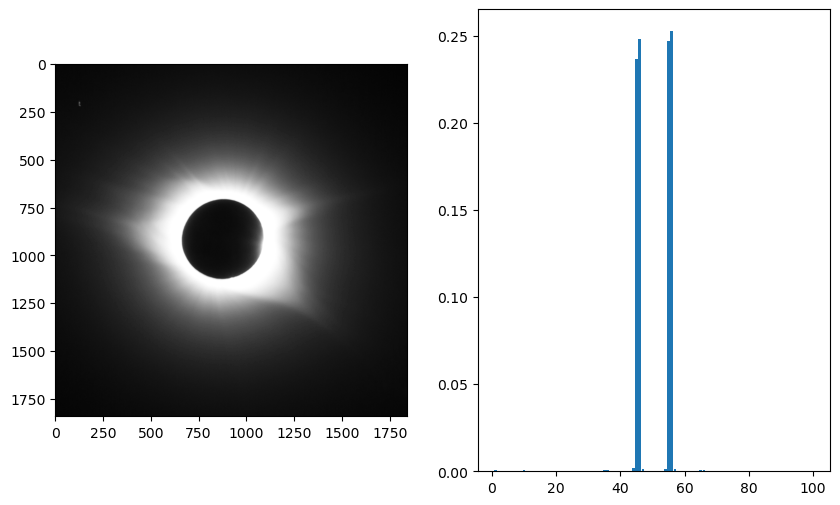

In [133]:
img_color = np.array(Image.open("eclipse-megamovie/test/0083b50624b619bb66705581d5c08e6fc2dc77574a979835ef01f96f9f19f8b1.jpg"))
img_gray = rgb2gray(img_color.astype("double"))

plt.figure(5, figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_gray)

num_bins_dxdy = 10
plt.subplot(1, 2, 2)
hist_dxdy_ = hist_dxdy(img_gray, num_bins_dxdy)
plt.bar(np.array(range(1, hist_dxdy_.size + 1)), hist_dxdy_)
plt.show()

In [42]:
def hist_intersect(h1: np.ndarray, h2: np.ndarray) -> float:
    """
    Compute the intersection between histograms x and y.
    Check that the distance range is [0,1].

    Args:
        h1 (np.ndarray): Input histogram.
        h2 (np.ndarray): Input histogram.

    Returns:
        x (float): Intersection distance between histograms x and y.
    """

    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    min_sum = np.sum(np.minimum(h1, h2))
    x = 0.5 * (min_sum / np.sum(h1) + min_sum / np.sum(h2))
    return x

def hist_l2(h1: np.ndarray, h2: np.ndarray) -> float:
    """
    Compute the L2 between x and y histograms.
    Check that the distance range in [0,sqrt(2)].

    Args:
        h1 (np.ndarray): Input histogram.
        h2 (np.ndarray): Input histogram.

    Returns:
        x (float): L2 distance between x and y histograms.
    """

    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    x = (np.sqrt(np.sum((h1-h2)**2)))
    
    return x


def hist_chi2(h1: np.ndarray, h2: np.ndarray) -> float:
    """
    Compute chi2 between x and y.
    Check that the distance range in [0,Inf].

    Args:
        h1 (np.ndarray): Input histogram.
        h2 (np.ndarray): Input histogram.

    Returns:
        x (float): Chi2 distance between x and y.
    """

    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    eps = 1 
    x = np.sum((h1 - h2)**2 / (h1 + h2 + eps)) 
  
    return x

def hist_ce(h1: np.ndarray, h2: np.ndarray) -> float:
    """
    Compute the cross-entropy between two histograms.

    Args:
        h1 (np.ndarray): First input histogram.
        h2 (np.ndarray): Second input histogram.

    Returns:
        float: Cross-entropy between h1 and h2.
    """
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    tmp = []
    for i in range(len(h1)):
        if h2[i] == 0:
            tmp.append(0)
        else:
            tmp.append(h1[i] * np.log(h2[i]))
    ce = -sum(tmp)
    return ce

In [110]:
def is_grayvalue_hist(hist_name: str) -> bool:
    """
    Handle function to discriminate when your input
    function is in gray_scale or colors.

    Args:
        hist_name (str): histogram name.

    Returns:
        bool: True if the histogram is in gray_scale, False otherwise.
    """
    if hist_name == "grayvalue" or hist_name == "dxdy":
        return True
    elif hist_name == "rgb" or hist_name == "gb":
        return False
    else:
        assert False, "unknown histogram type"


def get_hist_by_name(img: np.ndarray, num_bins_gray: int, hist_name: str) -> np.ndarray:
    """
    Handle function to get the correct historgam function
    by his name.

    Args:
        img (np.ndarray): input image.
        num_bins_gray (int): number of bins for the gray_scale histogram.

    Returns:
        np.ndarray: histogram.
    """
    if hist_name == "gb":
        return gb_hist(img, num_bins_gray)
    elif hist_name == "dxdy":
        return hist_dxdy(img, num_bins_gray)
    else:
        assert False, "unknown hist type: %s" % hist_name


def get_dist_by_name(x: np.ndarray, y: np.ndarray, dist_name: str) -> float:
    """
    Handle function to get the correct distance function
    by his name.

    Args:
        x (np.ndarray): input histogram.
        y (np.ndarray): input histogram.

    Returns:
        float: distance.
    """
    if dist_name == "chi2":
        return hist_chi2(x, y)
    elif dist_name == "intersect":
        return 1 - hist_intersect(x, y)
    elif dist_name == "l2":
        return hist_l2(x, y)
    elif dist_name == "ce":
        return hist_ce(x, y)
    elif dist_name == "all":
        pass
    else:
        assert False, "unknown distance: %s" % dist_name
        
def write_files(folder_path, output_file):
    """
    Crea un file di testo con i nomi delle immagini presenti in una cartella specificata.

    :param folder_path: Percorso della cartella contenente le immagini.
    :param output_file: Nome del file di output.
    """
    # Estensioni tipiche dei file immagine
    image_extensions = {".jpg", ".jpeg", ".png"}

    try:
        # Verifica se la cartella esiste
        if not os.path.isdir(folder_path):
            print(f"Errore: La cartella {folder_path} non esiste.")
            return

        # Ottieni i file nella cartella
        files = os.listdir(folder_path)

        # Filtra i file che hanno estensioni di immagine
        image_files = [file for file in files if os.path.splitext(file)[1].lower() in image_extensions]

        # Scrivi i nomi delle immagini nel file di output
        with open(output_file, "w") as f:
            for image_name in image_files:
                f.write(image_name + "\n")

        print(f"Elenco delle immagini salvato in {output_file}.")
    except Exception as e:
        print(f"Si è verificato un errore: {e}")
        

def read_files(
    model_path: str = "model.txt", query_path: str = "query.txt"
) -> Tuple[List[str], List[str]]:
    """
    Handle function to read query and model files.

    Args:
        model_path (str): path to the model file.
        query_path (str): path to the query file.

    Returns:
        Tuple[List[str], List[str]]: query images and model images.
    """
    with open(model_path) as fp:
        model_images = fp.readlines()
    model_images = [x.strip() for x in model_images]

    with open(query_path) as fp:
        query_images = fp.readlines()
    query_images = [x.strip() for x in query_images]

    return query_images, model_images

In [111]:
# note: use functions 'get_dist_by_name', 'get_hist_by_name' and 'is_grayvalue_hist' to obtain
#       handles to distance and histogram functions, and to find out whether histogram function
#       expects grayvalue or color image


def compute_histograms(
    image_list: List[np.ndarray], hist_type: str, hist_isgray: bool, num_bins: int
) -> List[np.ndarray]:
    """
    Compute the histogram for each image in image_list.

    Args:
        image_list (List[np.ndarray]): list of images.
        hist_type (str): histogram type.
        hist_isgray (bool): True if the histogram is in gray_scale, False otherwise.
        num_bins (int): number of bins for the gray_scale histogram.

    Returns:
        image_hist (List[np.ndarray]): list of histograms.
    """
    image_hist = []
    for img in image_list:
        if hist_isgray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Ensure the image is in float format
        img = img.astype(np.float32)

        # Check if dtype is 'float32' and not 'float64'
        if img.dtype != np.float32:
            raise ValueError(f"Image dtype is {img.dtype}, expected float32.")

        hist = get_hist_by_name(img, num_bins, hist_type)
        image_hist.append(hist)

    return image_hist


def find_best_match(
    model_images: List[str],
    query_images: List[str],
    dist_type: str,
    hist_type: str,
    num_bins: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Function to find the best match for each image in the
    query folder.

    Args:
        model_images (List[str]): list of strings with the path of model images.
        query_images (List[str]): list of strings with the path of query images.
        dist_type (str): a string to represent the name of the distance you want to use. Should be one among "l2", "intersect", "chi2".
        hist_type (str): a string to represent the name of the histogram you want to use. Should be one among "grayvalue", "rgb", "rg", "dxdy".
        num_bins (int): number of bins for the gray_scale histogram.

    Returns:
        best_match (np.ndarray): list containing in each position the index of the retrieved best matching image.
        D (np.ndarray): Matrix with |model_images| rows and |query_images| columns containing the scores of each matching.
    #"""
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    model_imgs = [cv2.imread(img) for img in model_images]
    query_imgs = [cv2.imread(img) for img in query_images]
    
    hist_isgray = is_grayvalue_hist(hist_type)
    model_hist = compute_histograms(model_imgs, hist_type, hist_isgray, num_bins)
    query_hist = compute_histograms(query_imgs, hist_type, hist_isgray, num_bins)
    
    # print("Model Histograms:", model_hist)
    # print("Query Histograms:", query_hist)
    
    D = np.zeros((len(model_imgs), len(query_imgs)))
    
    for i, m in enumerate(model_hist):
        for j, q in enumerate(query_hist):
            dist_value = get_dist_by_name(m, q, dist_type)
            # print(f"Distance between model {i} and query {j}: {dist_value}")
            D[i, j] = dist_value
            
    best_match = np.argmin(D, axis=0)

    return best_match, D


In [129]:
# model_images - list of file names of model images
# query_images - list of file names of query images

query_images, model_images = read_files()

dist_type = "chi2"
hist_type = "dxdy"
num_bins = 32

[best_match, D] = find_best_match(
    model_images, query_images, dist_type, hist_type, num_bins
)

print(
    "Indexes of correct retrieved images is:\n ",
    *np.where(best_match == np.arange(len(query_images)))
)
print(
    "The Recognition rate is",
    sum(best_match == np.arange(len(query_images))) / len(query_images),
)

Indexes of correct retrieved images is:
  [0 3 5 7]
The Recognition rate is 0.02857142857142857


In [77]:
def show_neighbors(
    model_images: List[str],
    query_images: List[str],
    dist_type: str,
    hist_type: str,
    num_bins: int,
) -> None:
    """
    For each image file from 'query_images' find and visualize the 5 nearest images from 'model_image'.

    Note: use the previously implemented function 'find_best_match'

    Args:
        model_images (List[str]): list of strings with the path of model images.
        query_images (List[str]): list of strings with the path of query images.
        dist_type (str): a string to represent the name of the distance you want to use. Should be one among "l2", "intersect", "chi2".
        hist_type (str): a string to represent the name of the histogram you want to use. Should be one among "grayvalue", "rgb", "rg", "dxdy".
        num_bins (int): number of bins for the gray_scale histogram.

    Returns:
        None
    """

    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################

    _ , D = find_best_match(model_images, query_images, dist_type, hist_type, num_bins)
    for i in range(D.shape[1]):
        sorted_indices = np.argsort(D[:, i])[:5]
        plt.figure(figsize=(15, 5))  

        plt.subplot(1, 6, 1)  
        query_img = plt.imread(query_images[i])  
        plt.imshow(query_img)
        plt.title('Query Image')  
        plt.axis('off')
        for idx, j in enumerate(sorted_indices):  
            plt.subplot(1, 6, idx + 2)  
            img = plt.imread(model_images[j])  
            plt.imshow(img)
            matching_value = D[j, i]  
            plt.title(f'M0 {matching_value:.2f}')  
            plt.axis('off')

        plt.tight_layout()  
        plt.show()  


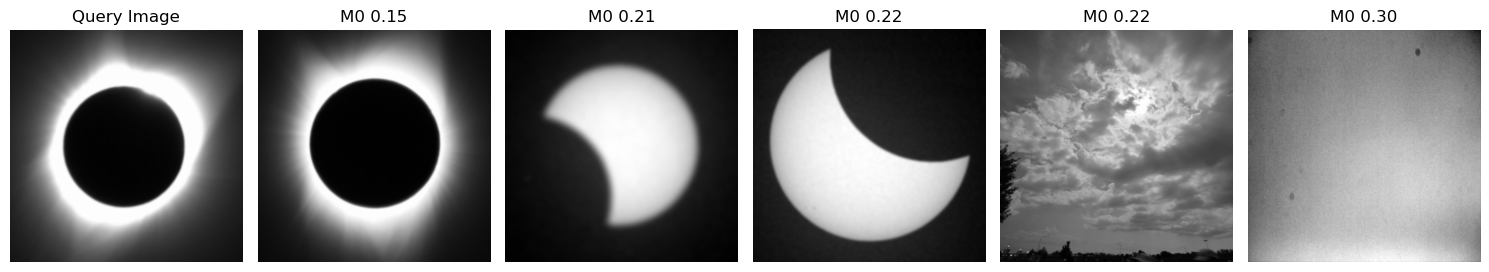

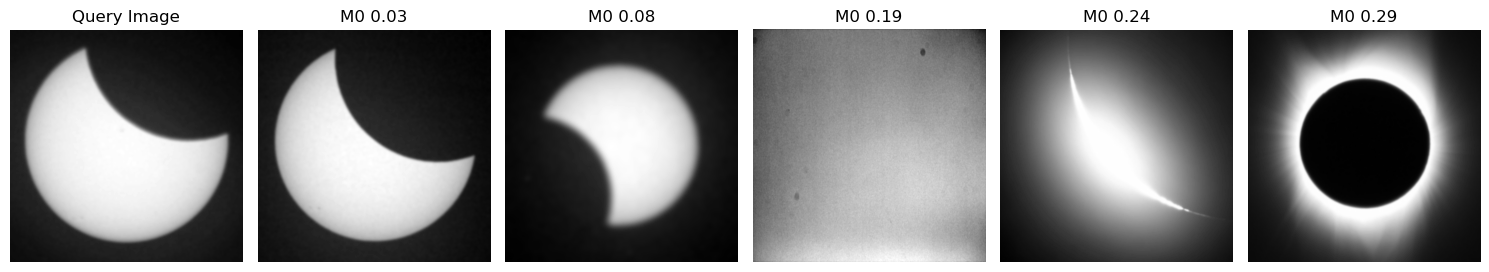

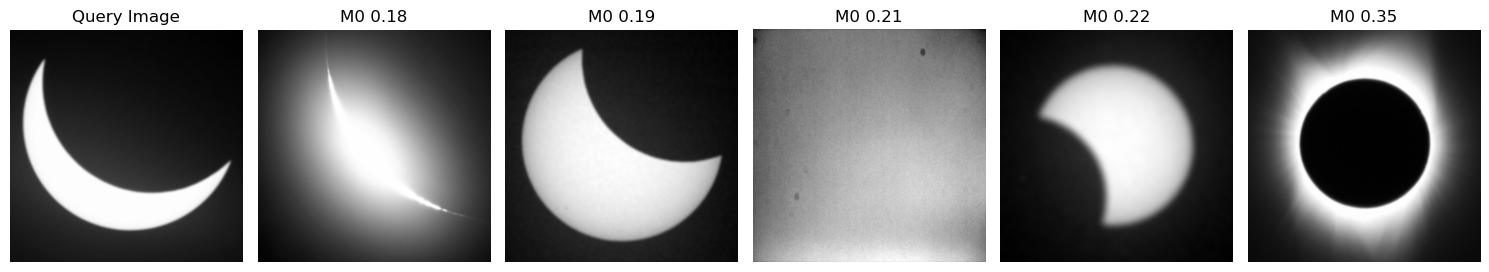

In [78]:
## visualize nearest neighbors
query_images_vis = [query_images[i] for i in np.array([0, 4, 9])]
show_neighbors(model_images, query_images_vis, 'intersect', hist_type, num_bins)

In [116]:
def topk_accuracy(y_true, y_pred, k:int) -> float:
    """
    Compute the Top-K accuracy, i.e. check whether the
    correct label is in the top-k results.

    Args:
        y_true (list): list of correct labels
        y_pred (np.array): A matrix of size (num_samples, num_results)
            where each cell contains the predicted score for each
            element in the dataset
        k (int): number of best matching items to consider

    Returns:
        topk_accuracy (float)
    """
    #####################################################
    ##                 YOUR CODE HERE                  ##
    #####################################################
    cnt = 0
    for i in range(len(y_true)):
        top_idx = np.argsort(y_pred[i])[:k]        
        if y_true[i] in top_idx:
            cnt += 1
    result = cnt / len(y_true)

    return result

In [117]:
if 'D' not in globals():
    _,D = find_best_match(
        model_images, query_images, dist_type, hist_type, num_bins
    )

y_true = np.arange(D.shape[0])

topk_accuracy(y_true, D, k=5)

0.125

ValueError: x, y, and format string must not be None

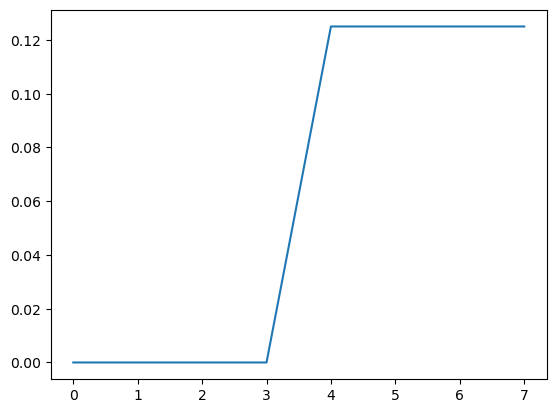

In [120]:
K = 8
y_true; # These are the correct labels

#####################################################
##                 YOUR CODE HERE                  ##
#####################################################
accuracies=[]
min_k = None
for i in range(K):
    accuracy = topk_accuracy(y_true, D, i)
    accuracies.append(accuracy)
    if accuracy >= 0.8 and min_k is None :
        min_accuracy = accuracy
        min_k = i
        print(f'The minimum value of k for which Top-k Accuracy is at least 80% is {i}')



j = range(0,K)
plt.plot(j, accuracies)
plt.plot(min_k, min_accuracy, 'ro')
plt.xticks(np.arange(min(j), max(j)+1, 1.0))
plt.yticks(np.arange(min(accuracies), 1.1, 0.1))
plt.xlabel('k')
plt.ylabel('Top-k Accuracy')
plt.show()
